In [ ]:
!nvidia-smi

Wed Apr  7 17:43:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.00132593days (114.56sec)


In [ ]:
!git clone https://github.com/yours-schnee/custom_ImageNet.git

Cloning into 'custom_ImageNet'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 57 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [ ]:
!pip install -e ./custom_ImageNet

ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content/custom_ImageNet


In [ ]:
import sys
sys.path.append('/content/custom_ImageNet')

In [ ]:
import custom_ImageNet
from utils.ImageNetDataset import make_path_list
from utils.ImageNetDataset import str_convert
from utils.ImageNetDataset import ImageNetDataset

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [ ]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "drive/My Drive/ImageNet/cortical_30random_ImagenetTrain.zip" /content/
!cp "drive/My Drive/ImageNet/cortical_ImagenetTest2.zip" /content/

In [ ]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
!7z x cortical_30random_ImagenetTrain.zip

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!mv "content/cortical_ImagenetTrain" ../content

In [ ]:
import shutil

directory = 'content'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

In [ ]:
!unzip -nq "cortical_ImagenetTest2.zip"

In [ ]:
def make_path_list_png(rootpath):
    """
    To create the list of file path about Image data and annotation data
    for training and test

    Inputs
    --------------------
    rootpath : str
        path data for data folder

    Returns
    --------------------
    *_img_list, *_anno_list
        list of path for each data
    """

    img_list = glob.glob(rootpath+'*/*.png')

    return img_list

In [ ]:
rootpathTrain ='cortical_ImagenetTrain/'
rootpathTest ='cortical_ImagenetTest2/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list_png(rootpathTest)

In [ ]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [ ]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [ ]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [ ]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

424704

In [ ]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


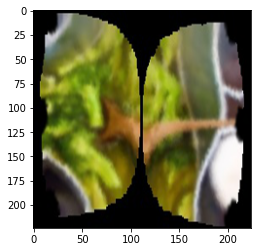

In [ ]:
index = 2
imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [ ]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [ ]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [ ]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

### CONST data

In [ ]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 10
else:
    NUM_EPOCS = 30

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Network model

In [ ]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.mobilenet_v2(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[1] = nn.Linear(in_features=1280, out_features=N_CLASSES)

net.cuda()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

### Loss function

In [ ]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Optimization method

In [ ]:
# Optimization setting
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

### Training & Test for model

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_corrects = 0  # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_corrects += preds.eq(labels.view_as(preds)).sum().item()

            print(epoch_corrects)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_corrects / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%2==0:
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
        print('-------------')

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

In [ ]:
LOAD_STATE = False
EPOCH = 40             # This values need to check the latest tar ffile name with epoch.
name = "07_mobilenet"
folder_name = "mobilenet"

if LOAD_STATE:
    stats=[];
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    best_model = net
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = 0#checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    net.load_state_dict( checkpoint["model_state_dict"] )
    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=net;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [ ]:
best_model, stats = train_model(net, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, "mobilenet", DEBUG)

Epoch 1/30
-------------



276320
train Loss: 0.0344 Acc: 65.0618



76924
val Loss: 0.0270 Acc: 72.4495
-------------
Epoch 2/30
-------------



319434
train Loss: 0.0241 Acc: 75.2133



83364
val Loss: 0.0209 Acc: 78.5149
-------------
Epoch 3/30
-------------



337388
train Loss: 0.0198 Acc: 79.4407



86460
val Loss: 0.0179 Acc: 81.4308
-------------
Epoch 4/30
-------------



350989
train Loss: 0.0166 Acc: 82.6432



89832
val Loss: 0.0148 Acc: 84.6067
-------------
Epoch 5/30
-------------



360722
train Loss: 0.0143 Acc: 84.9349



91780
val Loss: 0.0131 Acc: 86.4414
-------------
Epoch 6/30
-------------



369650
train Loss: 0.0123 Acc: 87.0371



92090
val Loss: 0.0126 Acc: 86.7333
-------------
Epoch 7/30
-------------



376951
train Loss: 0.0106 Acc: 88.7562



94421
val Loss: 0.0106 Acc: 88.9288
-------------
Epoch 8/30
-------------



383242
train Loss: 0.0091 Acc: 90.2374



95863
val Loss: 0.0093 Acc: 90.2869
-------------
Epoch 9/30
-------------



388014
train Loss: 0.0080 Acc: 91.3610



97330
val Loss: 0.0080 Acc: 91.6686
-------------
Epoch 10/30
-------------



392509
train Loss: 0.0070 Acc: 92.4194



97368
val Loss: 0.0080 Acc: 91.7043
-------------
Epoch 11/30
-------------



396433
train Loss: 0.0062 Acc: 93.3434



98260
val Loss: 0.0073 Acc: 92.5445
-------------
Epoch 12/30
-------------



399503
train Loss: 0.0055 Acc: 94.0662



98863
val Loss: 0.0067 Acc: 93.1124
-------------
Epoch 13/30
-------------



402035
train Loss: 0.0049 Acc: 94.6624



99399
val Loss: 0.0063 Acc: 93.6172
-------------
Epoch 14/30
-------------



404345
train Loss: 0.0044 Acc: 95.2063



99834
val Loss: 0.0059 Acc: 94.0269
-------------
Epoch 15/30
-------------



406376
train Loss: 0.0040 Acc: 95.6845



99969
val Loss: 0.0059 Acc: 94.1540
-------------
Epoch 16/30
-------------



407969
train Loss: 0.0036 Acc: 96.0596



100032
val Loss: 0.0057 Acc: 94.2134
-------------
Epoch 17/30
-------------



409290
train Loss: 0.0033 Acc: 96.3706



100621
val Loss: 0.0052 Acc: 94.7681
-------------
Epoch 18/30
-------------



410504
train Loss: 0.0031 Acc: 96.6565



100726
val Loss: 0.0051 Acc: 94.8670
-------------
Epoch 19/30
-------------



411918
train Loss: 0.0028 Acc: 96.9894



100842
val Loss: 0.0050 Acc: 94.9763
-------------
Epoch 20/30
-------------



412868
train Loss: 0.0026 Acc: 97.2131



101083
val Loss: 0.0048 Acc: 95.2032
-------------
Epoch 21/30
-------------



413880
train Loss: 0.0023 Acc: 97.4514



101223
val Loss: 0.0048 Acc: 95.3351
-------------
Epoch 22/30
-------------



414316
train Loss: 0.0022 Acc: 97.5541



101173
val Loss: 0.0050 Acc: 95.2880
-------------
Epoch 23/30
-------------



415052
train Loss: 0.0021 Acc: 97.7274



101707
val Loss: 0.0043 Acc: 95.7910
-------------
Epoch 24/30
-------------



415757
train Loss: 0.0019 Acc: 97.8934



101607
val Loss: 0.0045 Acc: 95.6968
-------------
Epoch 25/30
-------------



416442
train Loss: 0.0018 Acc: 98.0546



101520
val Loss: 0.0046 Acc: 95.6148
-------------
Epoch 26/30
-------------



416806
train Loss: 0.0017 Acc: 98.1404



101911
val Loss: 0.0044 Acc: 95.9831
-------------
Epoch 27/30
-------------



417165
train Loss: 0.0016 Acc: 98.2249



101909
val Loss: 0.0043 Acc: 95.9812
-------------
Epoch 28/30
-------------



417611
train Loss: 0.0015 Acc: 98.3299



102287
val Loss: 0.0040 Acc: 96.3372
-------------
Epoch 29/30
-------------



418198
train Loss: 0.0014 Acc: 98.4681



102237
val Loss: 0.0040 Acc: 96.2901
-------------
Epoch 30/30
-------------



418393
train Loss: 0.0014 Acc: 98.5140



102111
val Loss: 0.0040 Acc: 96.1715
-------------
Lowest training loss 0.0013757514810073192
Lowest validation loss 0.0039766402436404655
Highest training accuracy 98.51402388487041
Highest validation accuracy 96.33721368294154
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/06_mobilenet_Loss _.png06_mobilenet_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/06_mobilenet_Accuracy _.png06_mobilenet_Accuracy _.png


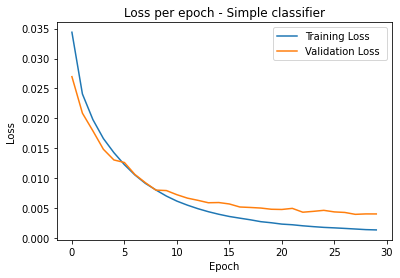

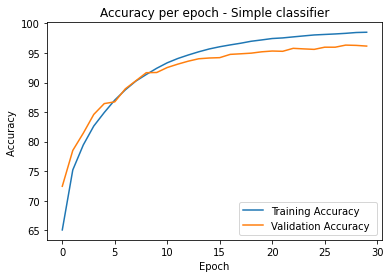

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 0.2926 
Testing Accuracy: 1878/2000 (93.90%)
apple Class Accuracy: 92/100 (92.00%)
banana Class Accuracy: 94/100 (94.00%)
bear Class Accuracy: 98/100 (98.00%)
bell_pepper Class Accuracy: 94/100 (94.00%)
bird Class Accuracy: 94/100 (94.00%)
broccoli Class Accuracy: 95/100 (95.00%)
cat Class Accuracy: 93/100 (93.00%)
cauliflower Class Accuracy: 93/100 (93.00%)
cow Class Accuracy: 91/100 (91.00%)
dog Class Accuracy: 90/100 (90.00%)
elephant Class Accuracy: 93/100 (93.00%)
fox Class Accuracy: 96/100 (96.00%)
goat Class Accuracy: 93/100 (93.00%)
horse Class Accuracy: 92/100 (92.00%)
mashed_potato Class Accuracy: 94/100 (94.00%)
orange Class Accuracy: 92/100 (92.00%)
pineapple Class Accuracy: 95/100 (95.00%)
pomegranate Class Accuracy: 95/100 (95.00%)
tomato Class Accuracy: 97/100 (97.00%)
zebra Class Accuracy: 97/100 (97.00%)
Classifier has Acc=0.939 P=0.939 R=0.940 F1=0.939
               precision    recall  f1-score   support

        apple       0.91      0.92      0.92     

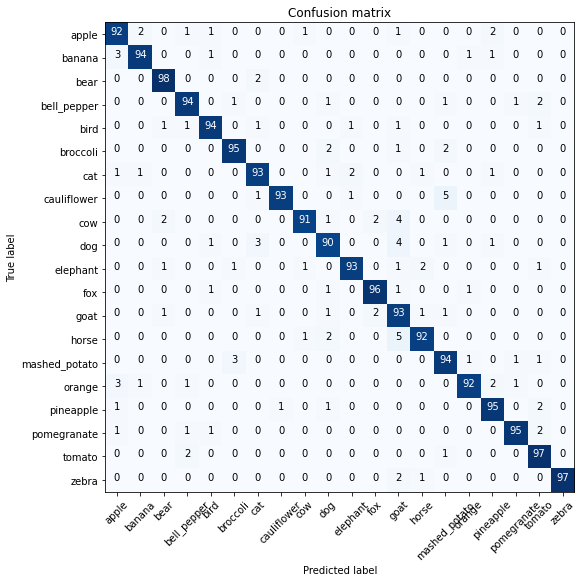

In [ ]:
result = test_model(best_model, criterion, name)